# Include S6, S7, H1, H2, and OBJ into the GP model

**Note**: In order to use it on a specific machine, you should build machine interface (setX and get_state functions).


In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import pickle
import numpy as np
from modules.bayes_optimization import BayesOpt, negUCB, negExpImprove
from modules.OnlineGP import OGP
import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import sys
import os
sys.path.insert(1, '/home/chenyu/Desktop/GaussianProcess/GPTrelated')
saveResultsQ = False
import scipy
import tensorflow as tf
# %matplotlib qt
# %matplotlib

failed to import parallelstuff


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
os.environ["CUDA_VISIBLE_DEVICES"]="0" # specify which GPU to use
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [7]:
# free space from GPU device
from numba import cuda
cuda.select_device(0)
cuda.close()

### Creat the machine interface

In [3]:
ndim = 7 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
# Parameters in the order of H1, H1-H2, S1, S2, S3, S4, S6, S7
iter_bounds = [(1000,2200),(-2,2),(3.87e5, 3.91e5), (-6.55e5, -6.40e5),(-3.7511e6, -3.7497e6),(1.19e5, 1.203e5),(6.4e5,6.51e5)]  # hard coded boundary for now.
rs = np.random.RandomState()
start_point = [[x[0] + (rs.rand()*(x[1]-x[0])) for x in iter_bounds]]
print(start_point)

#creat machine interface
mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point, CNNoption=1) 

[[1919.8043413403848, 1.5271977112107802, 388933.6391666969, -652306.4409192496, -3750605.96540601, 119325.35862931717, 640381.8436611011]]


Using TensorFlow backend.


Model loaded


[[ 1.91980434e+03  1.52719771e+00  3.88933639e+05 -6.52306441e+05
  -3.75060597e+06  1.19325359e+05  6.40381844e+05]]


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


-0.5216303


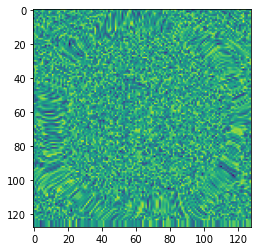

In [4]:
print(mi.x)
#check the reading objective is working
temp = mi.getState()
print(temp[1][0][0])
temp = np.load('ronchigram.npy')
plt.imshow(temp)
# print(GPT_emit())

In [20]:
#check noise std
y = [mi.getState()[1][0] for x in range(5)]
np.std(y)

0.0

### Create the gp

In [5]:
# hyperparameters determined using GPy for emittance from CNN
gp_ls = np.array(np.ones(ndim)) * [0.485, 0.138, 0.634, 0.177, 0.976, 1.669, 1.230] * 5
gp_amp = 0.0587

gp_noise = 0.0587  # default = 0.001

gp_precisionmat =  np.array(np.diag(1/(gp_ls**2)))
hyps = [gp_precisionmat, np.log(gp_amp), np.log(gp_noise**2)] #format the hyperparams for the OGP

gp = OGP(ndim, hyps,prmean=0)

In [6]:
gp_ls

array([2.425, 0.69 , 3.17 , 0.885, 4.88 , 8.345, 6.15 ])

### Create the BO

In [7]:
#create the bayesian optimizer that will use the gp as the model to optimize the machine 
opt = BayesOpt(gp, mi, acq_func="UCB", start_dev_vals = mi.x, dev_ids = dev_ids)
# opt.ucb_params = np.array([0.002, 0.4])
opt.ucb_params = np.array([2, None])

target_func =  <machine_interfaces.machine_interface_GPT.machine_interface object at 0x7fc0fad33cf8>
********* BO - self.mi = self.target_func wORKED!
Supposed to be grabbing initial machine state...
x_init [[ 1.91980434e+03  1.52719771e+00  3.88933639e+05 -6.52306441e+05
  -3.75060597e+06  1.19325359e+05  6.40381844e+05]]
y_init [[-0.5216303]]
Using prior mean function of  0
Using prior mean parameters of  None


**Running BO**

*run the gp search for some number of steps*

In [8]:
Obj_state_s=[]
Obj_state_s.append(mi.getState()[1][0])

In [9]:
def GPT_emit():
    ASCIIFILE = '/home/chenyu/Desktop/GaussianProcess/outscope.txt'
    screen =  np.loadtxt(ASCIIFILE, skiprows=5)
            
    x  = screen[:,0]
    y  = screen[:,1]
    x = x * 1e12
    y = y * 1e12  # x and y in unit of pm

    ax = np.divide(screen[:,4], screen[:,6])
    ay = np.divide(screen[:,5], screen[:,6])
    arx = np.sqrt(ax**2 + ay**2)
    index = np.where(arx < 0.04)

    x = x[index]
    y = y[index]
    ax = ax[index]
    ay = ay[index]

    # directly calculate emittance from defination for all the simulated electrons
    emit_1 = np.average(x**2 + y**2)
    emit_2 = np.average(ax**2 + ay**2)
    emit_3 = np.average(x*ax + y*ay)
    emit = np.sqrt(emit_1 * emit_2 - emit_3**2) # emittance in unit of [pm*rad]
    
    return -emit

In [10]:
# Test over single starting point
Niter = 300
Status_array = np.zeros([Niter + 1, 10]) # save the
Status_array[0,0] = Status_array[0,1] = mi.getState()[1][0]
Status_array[0,2] = GPT_emit()

Status_array[0,3] = opt.current_x[0][0]
Status_array[0,4] = opt.current_x[0][1]
Status_array[0,5] = opt.current_x[0][2]
Status_array[0,6] = opt.current_x[0][3]
Status_array[0,7] = opt.current_x[0][4]
Status_array[0,8] = opt.current_x[0][5]
Status_array[0,9] = opt.current_x[0][6]

Ronch_array = []

for i in range(Niter):
    
    print ('iteration =', i)
    fig = plt.figure(figsize=(4,4))
    temp = np.load('ronchigram.npy')
    Ronch_array.append(temp)
    
    fig = plt.figure(figsize=[20,8])
    plt.subplot(121)

    plt.plot(-Status_array[0:-1,1],'-',c='C0', label = 'Acquisition Point')
    plt.plot(-Status_array[0:-1,0],c='C1', label = 'Best Seen')
    plt.yscale('log')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16)
    # plt.legend(fontsize=16, bbox_to_anchor=[0.9, 0.1],loc = 'lower right')
    plt.xlabel('Iteration #', fontsize = 16)
    plt.ylabel('$\epsilon_\chi$ (pm\u2022rad)', fontsize=16)

    plt.subplot(122)
    plt.imshow(temp)
    plt.show()
    
    clear_output(wait=True)
    
    
    # Start of new iteration
    temp = opt.OptIter() # save the new acquisition point and objective value
    Obj_state_s.append(opt.best_seen()[1]) # save current best value
    Status_array[i+1, 0] = opt.best_seen()[1][0][0]  # best seen objective so far
    Status_array[i+1, 1] = temp[1][0][0]  # objective at new point
    Status_array[i+1, 2] = GPT_emit()     # objective provided by GPT profile, as a reference
    
    Status_array[i+1, 3] = temp[0][0][0]  # coordinate of new state
    Status_array[i+1, 4] = temp[0][0][1]
    Status_array[i+1, 5] = temp[0][0][2]
    Status_array[i+1, 6] = temp[0][0][3]
    Status_array[i+1, 7] = temp[0][0][4]
    Status_array[i+1, 8] = temp[0][0][5]
    Status_array[i+1, 9] = temp[0][0][6]
    
    print(opt.best_seen())

/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


New State: [[ 1.11060244e+03 -2.97055339e+00  3.89091669e+05 -6.46153509e+05
  -3.75067791e+06  1.20003912e+05  6.46123873e+05]], [[-0.2714718]]
(array([ 1.92977800e+03, -5.23152328e-01,  3.92954718e+05, -6.41346257e+05,
       -3.75027485e+06,  1.19996707e+05,  6.48979808e+05]), array([[-0.03547814]], dtype=float32))


In [11]:
np.save('HP-TL-Obj_1000e_UCB_2-0_Emit_300iter_oldWhiteNoise_01.npy',Status_array)
np.save('HP-TL-Obj_1000e_UCB_2-0_Emit_300iter_oldWhiteNoise_Ronchigram_01.npy',Ronch_array)

Model loaded
[[ 1.92977800e+03 -5.23152328e-01  3.92954718e+05 -6.41346257e+05
  -3.75027485e+06  1.19996707e+05  6.48979808e+05]]
(array([[ 1.92977800e+03, -5.23152328e-01,  3.92954718e+05,
        -6.41346257e+05, -3.75027485e+06,  1.19996707e+05,
         6.48979808e+05]]), array([[-0.03547814]], dtype=float32))


Text(0, 0.5, '$y^\\prime \\ \\mathrm{(mrad)}$')

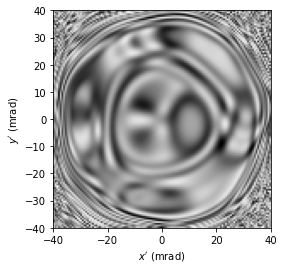

In [26]:
start_point = [opt.best_seen()[0]]
mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point, CNNoption=1)
print(mi.x)
print(mi.getState())
temp = np.load('ronchigram.npy')
plt.imshow(temp,extent=[-40,40,-40,40],cmap='gray')
# plt.axis('off')
plt.xlabel(r"$x^\prime \ \mathrm{(mrad)}$")
plt.ylabel(r"$y^\prime \ \mathrm{(mrad)}$")

In [10]:
Status_array = np.load('GPruns/H1-H2-S6-S7-Obj_1000e_UCB_2-0_500iter_02.npy')
Ronch_array = np.load('GPruns/H1-H2-S6-S7-Obj_1000e_UCB_2-0_500iter_Ronchigram_02.npy')

In [17]:
# reshape the status_array for hyperparameter training
Status_array.shape
Obj_x = Status_array[:,3:10]
Obj_y = Status_array[:,1]
np.save('Obj_x_GPrun.npy', Obj_x)
np.save('Obj_y_GPrun.npy', Obj_y)
print(Obj_x.shape)

(301, 7)


In [30]:
print(Status_array[0,1])

-0.5216302871704102


Text(0, 0.5, '$y^\\prime \\ \\mathrm{(mrad)}$')

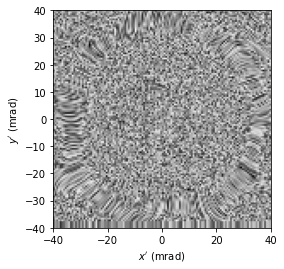

In [28]:
# plt.imshow(Ronch_array[np.argmax(Status_array[:,1]),:,:], extent=[-40,40,-40,40],cmap='gray')
plt.imshow(Ronch_array[0], extent=[-40,40,-40,40],cmap='gray')
# plt.axis('off')
plt.xlabel(r"$x^\prime \ \mathrm{(mrad)}$")
plt.ylabel(r"$y^\prime \ \mathrm{(mrad)}$")

Text(0, 0.5, '$\\epsilon_\\chi$ (pm•rad)')

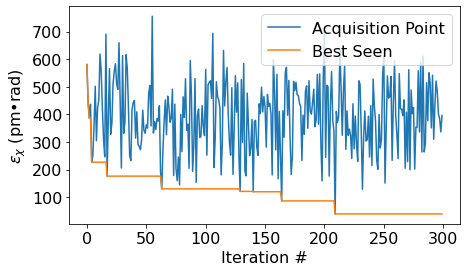

In [20]:
fig = plt.figure(figsize = (7,4))

plt.subplot(111)
plt.plot(-Status_array[0:-1,1]*1112.7,'-',c='C0', label = 'Acquisition Point')
plt.plot(-Status_array[0:-1,0]*1112.7,c='C1', label = 'Best Seen')
# plt.yscale('log')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
# plt.legend(fontsize=16, bbox_to_anchor=[0.9, 0.1],loc = 'lower right')
plt.xlabel('Iteration #', fontsize = 16)
plt.ylabel('$\epsilon_\chi$ (pm\u2022rad)', fontsize=16)
# plt.xlim([0,100])

In [29]:
np.amax(Status_array[0:-1,1]*1112.7)

-39.476531812548636

Text(0, 0.5, 'HP 1')

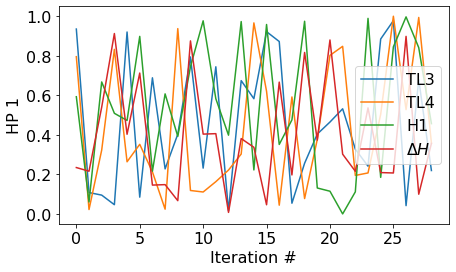

In [24]:
fig = plt.figure(figsize = (7,4))

plt.subplot(111)
plt.plot((Status_array[-30:-1,5] - np.amin(Status_array[0:-1,5]))/(np.amax(Status_array[0:-1,5])-np.amin(Status_array[0:-1,5])),c='C0', label = 'TL3')
plt.plot((Status_array[-30:-1,6] - np.amin(Status_array[0:-1,6]))/(np.amax(Status_array[0:-1,6])-np.amin(Status_array[0:-1,6])),c='C1', label = 'TL4')
plt.plot((Status_array[-30:-1,4] - np.amin(Status_array[0:-1,4]))/(np.amax(Status_array[0:-1,4])-np.amin(Status_array[0:-1,4])),c='C2', label = 'H1')
plt.plot((Status_array[-30:-1,3] - np.amin(Status_array[0:-1,3]))/(np.amax(Status_array[0:-1,3])-np.amin(Status_array[0:-1,3])),c='C3', label = '$\Delta H$')

# plt.yscale('log')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
# plt.legend(fontsize=16, bbox_to_anchor=[0.9, 0.1],loc = 'lower right')
plt.xlabel('Iteration #', fontsize = 16)
plt.ylabel('HP 1', fontsize=16)
# plt.xlim([0,100])

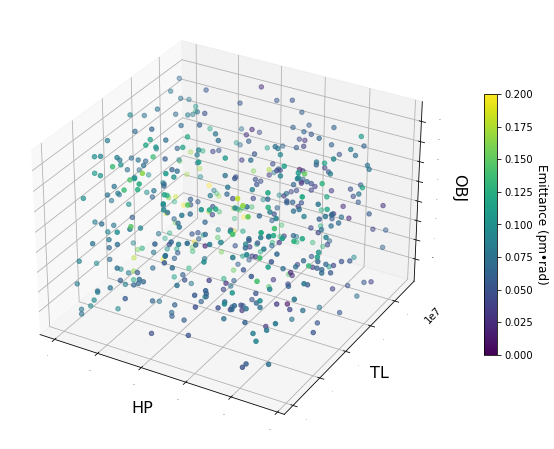

In [36]:
fig = plt.figure(figsize=[15,8])
ax = fig.add_subplot(111, projection='3d')

x_cor = (Status_array[:,3]-1000)*4 + (Status_array[:,4]+2) # from H1 and deltaH
y_cor = (Status_array[:,5]-3.87e5)*0.15e5 + (Status_array[:,6]+6.55e5) # from S6 and S7
z_cor = Status_array[:,7] + 3.7511e6 # from Obj
p = ax.scatter(x_cor, y_cor, z_cor, c=-Status_array[:,1],vmin=0, vmax=0.2)

ax.set_xlabel('HP', fontsize=16)
ax.set_ylabel('TL', fontsize=16)
ax.set_zlabel('OBJ', fontsize=16, rotation=270)
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(0)
cbar = fig.colorbar(p, shrink=0.6)
plt.xticks(fontsize=0)
plt.yticks(fontsize=0)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Emittance (pm\u2022rad)',fontsize = 12, rotation=270)

plt.show()

## Test different random starting points

In [ ]:
# Test over multiple different starting point
Niter = 150
Ntest_point = 10  # total number of test points

# Parameters in the order of H1, H1-H2, S1, S2, S3, S4, S6, S7
iter_bounds = [(1000,2200),(-2,2),(3.87e5, 3.91e5), (-6.55e5, -6.40e5),(-3.7511e6, -3.7497e6)]  # hard coded boundary for now.


Obj_list = np.zeros((Ntest_point, Niter + 3))

for itest in range(Ntest_point):
    rs = np.random.RandomState()
    count = itest
    if Obj_list[count,Niter+2] != 0:
        break

    rs = np.random.RandomState()
    start_point = [[x[0] + (rs.rand()*(x[1]-x[0])) for x in iter_bounds]]
    print(start_point)
    # For each starting point, create a new mi with the new start_point par, then a new opt to connect to the new mi
    mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) 
    
    gp_ls = np.array(np.ones(ndim)) * [0.982, 1, 0.773, 0.821, 0.56]
    gp_amp = 0.02
    gp_noise = 5.91e-5  # default = 0.001

    gp_precisionmat =  np.array(np.diag(1/(gp_ls**2)))
    hyps = [gp_precisionmat, np.log(gp_amp), np.log(gp_noise**2)] #format the hyperparams for the OGP

    gp = OGP(ndim, hyps,prmean=0)

    opt = BayesOpt(gp, mi, acq_func="UCB", start_dev_vals = mi.x, dev_ids = dev_ids)
    opt.ucb_params = np.array([2, None])
    Obj_list[count,0] = start_point[0][0]  # starting points
    Obj_list[count,1] = start_point[0][1]
    Obj_list[count,2] = mi.getState()[1][0]  # initial state

    for i in range(Niter):
        opt.OptIter()
        Obj_list[count,i+3] = opt.best_seen()[1]  # save the best objective in each iteration
#             Obj_state_s.append(opt.best_seen()[1])
    print(str(start_point[0][0]) + ', ' + str(start_point[0][1]) + ', ' + str(itest)+ ' Finished.')
    np.save('DiffStarPointTest_HP_S6-7_Obj_150iter_10pts.npy',Obj_list)

[[2164.556194487448, 0.974831850202579, 388652.3809520174, -651549.7111696949, -3750751.112478747]]
target_func =  <machine_interfaces.machine_interface_GPT.machine_interface object at 0x7fb39d1d09b0>
********* BO - self.mi = self.target_func wORKED!
Supposed to be grabbing initial machine state...
x_init [[ 2.16455619e+03  9.74831850e-01  3.88652381e+05 -6.51549711e+05
  -3.75075111e+06]]
y_init [[-34.17425606]]
Using prior mean function of  0
Using prior mean parameters of  None
New State: [[ 1.57875898e+03 -7.43326779e-01  3.91886057e+05 -6.51583421e+05
  -3.75068117e+06]], [[-39.12922175]]
New State: [[ 1.92968529e+03  2.20248477e+00  3.91099091e+05 -6.48850405e+05
  -3.74979859e+06]], [[-29.07696147]]
New State: [[ 1.41847180e+03 -2.88542311e+00  3.91265302e+05 -6.53179337e+05
  -3.75001617e+06]], [[-53.70546271]]
New State: [[ 1.30518432e+03 -4.32749380e-01  3.90904879e+05 -6.47814135e+05
  -3.75074336e+06]], [[-81.86257966]]
New State: [[ 1.10079314e+03 -8.93824594e-01  3.877084

New State: [[ 1.30975561e+03  3.49992094e-01  3.91990664e+05 -6.50668517e+05
  -3.74968733e+06]], [[-69.38985889]]
New State: [[ 2.02061020e+03  7.26467455e-01  3.92631024e+05 -6.43438111e+05
  -3.75046717e+06]], [[-28.49946006]]
New State: [[ 1.43453251e+03 -2.34635183e+00  3.92707919e+05 -6.50418072e+05
  -3.75110187e+06]], [[-49.18789133]]
New State: [[ 1.51251624e+03  1.32864896e+00  3.90641024e+05 -6.48051351e+05
  -3.74951327e+06]], [[-62.346006]]
New State: [[ 1.52905379e+03  2.94214911e+00  3.90972375e+05 -6.51365626e+05
  -3.75003021e+06]], [[-50.87592201]]
New State: [[ 1.06654390e+03 -1.30129453e+00  3.87523923e+05 -6.51876856e+05
  -3.75096365e+06]], [[-126.14529582]]
New State: [[ 1.20847917e+03  1.29545167e+00  3.92231449e+05 -6.54020114e+05
  -3.75062978e+06]], [[-75.11080783]]
New State: [[ 1.03384013e+03 -2.67839519e+00  3.88126387e+05 -6.47048741e+05
  -3.74983483e+06]], [[-130.74597027]]
New State: [[ 2.13889753e+03 -1.73035259e+00  3.90048282e+05 -6.43038490e+05
  -

New State: [[ 2.00364569e+03 -1.61318229e+00  3.90230657e+05 -6.54768120e+05
  -3.74968515e+06]], [[-27.79050177]]
New State: [[ 1.57690027e+03  1.01495357e+00  3.88977972e+05 -6.47599007e+05
  -3.75064843e+06]], [[-65.875305]]
New State: [[ 2.02999003e+03 -2.19728020e-01  3.92071668e+05 -6.40609211e+05
  -3.74986578e+06]], [[-34.42906651]]
New State: [[ 1.31021983e+03  2.96007482e+00  3.88758969e+05 -6.45036659e+05
  -3.74979235e+06]], [[-98.60489237]]
New State: [[ 1.94323261e+03  1.25167894e+00  3.87574399e+05 -6.44187499e+05
  -3.75019285e+06]], [[-60.50350537]]
New State: [[ 1.79504953e+03 -2.32191383e+00  3.90730643e+05 -6.47228094e+05
  -3.75021379e+06]], [[-39.46733426]]
New State: [[ 2.02593488e+03 -5.06539257e-01  3.88449666e+05 -6.47513090e+05
  -3.74955707e+06]], [[-43.77868637]]
New State: [[ 1.98088412e+03 -1.32992391e+00  3.87237523e+05 -6.45010958e+05
  -3.74995750e+06]], [[-56.81314116]]
New State: [[ 1.23751940e+03  2.03645114e-01  3.87426337e+05 -6.48321665e+05
  -3.

New State: [[ 1.71302033e+03 -2.30951882e+00  3.92945456e+05 -6.47357458e+05
  -3.75033640e+06]], [[-30.56927548]]
New State: [[ 1.43012249e+03 -1.26326275e+00  3.90341691e+05 -6.43977300e+05
  -3.75142766e+06]], [[-79.61864196]]
New State: [[ 1.96528645e+03  1.86400709e+00  3.87852432e+05 -6.44307889e+05
  -3.75035238e+06]], [[-57.10385051]]
New State: [[ 2.08246979e+03  2.33752643e+00  3.92780888e+05 -6.42314692e+05
  -3.75028031e+06]], [[-28.55134523]]
New State: [[ 2.17279362e+03 -3.94128954e-01  3.92579922e+05 -6.50427717e+05
  -3.75117698e+06]], [[-35.97559991]]
New State: [[ 1.81318543e+03  5.43617545e-01  3.87796826e+05 -6.50129209e+05
  -3.74989914e+06]], [[-53.14520178]]
New State: [[ 2.19777064e+03 -1.45343160e+00  3.90349151e+05 -6.50504019e+05
  -3.75061673e+06]], [[-29.86951357]]
New State: [[ 1.58467093e+03 -2.37893018e+00  3.92788314e+05 -6.44632605e+05
  -3.75055479e+06]], [[-45.96868678]]
New State: [[ 2.08366207e+03  1.51844731e-01  3.87616336e+05 -6.43578394e+05
  -

New State: [[ 1.28718951e+03  2.42820044e+00  3.89872740e+05 -6.54866068e+05
  -3.75064561e+06]], [[-78.90872818]]
New State: [[ 1.44594607e+03 -1.62564598e+00  3.88660105e+05 -6.54353475e+05
  -3.75010183e+06]], [[-69.39542588]]
New State: [[ 1.45889541e+03 -2.66013620e-01  3.88542711e+05 -6.41112909e+05
  -3.74959626e+06]], [[-90.74343843]]
New State: [[ 1.97854597e+03  2.90771798e+00  3.88112568e+05 -6.43573155e+05
  -3.75043761e+06]], [[-55.00491262]]
New State: [[ 1.57760533e+03 -2.84490977e+00  3.87805704e+05 -6.54473517e+05
  -3.75072992e+06]], [[-63.28741134]]
New State: [[ 1.14386349e+03 -9.44691236e-01  3.91567100e+05 -6.46052153e+05
  -3.75058303e+06]], [[-106.36217941]]
New State: [[ 2.17121378e+03 -2.29348319e+00  3.91830312e+05 -6.49926926e+05
  -3.75080840e+06]], [[-30.82899626]]
New State: [[ 1.18240376e+03  2.58487214e-01  3.89923840e+05 -6.45673464e+05
  -3.75107881e+06]], [[-107.45691057]]
New State: [[ 1.92057554e+03 -3.39203672e-02  3.90932731e+05 -6.43464150e+05
 

New State: [[ 1.02845633e+03  5.88939249e-01  3.92217752e+05 -6.54613621e+05
  -3.74990699e+06]], [[-111.36999967]]
New State: [[ 2.13816301e+03 -1.10032507e+00  3.89630348e+05 -6.47551200e+05
  -3.74992694e+06]], [[-32.19117141]]
New State: [[ 1.00033820e+03  1.91448556e+00  3.90736264e+05 -6.41835759e+05
  -3.75109417e+06]], [[-136.61834121]]
New State: [[ 1.13719450e+03  2.42671361e+00  3.90149160e+05 -6.51643414e+05
  -3.74985224e+06]], [[-104.41543929]]
New State: [[ 1.41310810e+03  1.13554758e+00  3.92847036e+05 -6.43400190e+05
  -3.75106410e+06]], [[-65.69328865]]
New State: [[ 1.96164658e+03 -3.16913711e-01  3.92334441e+05 -6.45427060e+05
  -3.74992882e+06]], [[-26.73746545]]
New State: [[ 1.07809777e+03 -6.14258294e-01  3.87493071e+05 -6.45141964e+05
  -3.75044725e+06]], [[-129.35408607]]
New State: [[ 2.09170599e+03 -9.29595326e-01  3.91626462e+05 -6.48632379e+05
  -3.74951211e+06]], [[-28.51192785]]
New State: [[ 1.27017866e+03  2.91305153e+00  3.90166473e+05 -6.54387608e+05

New State: [[ 1.03824687e+03  2.06320171e+00  3.87300184e+05 -6.40659545e+05
  -3.75067072e+06]], [[-138.00352578]]
New State: [[ 1.18369909e+03 -2.02666740e+00  3.92296273e+05 -6.42673774e+05
  -3.75112190e+06]], [[-100.10796913]]
New State: [[ 1.71863165e+03  1.13390202e+00  3.91927427e+05 -6.53532472e+05
  -3.75074407e+06]], [[-28.03673711]]
New State: [[ 1.85231064e+03 -2.41834494e+00  3.88883296e+05 -6.53310631e+05
  -3.75078844e+06]], [[-38.60113797]]
New State: [[ 1.12483857e+03 -2.23255795e+00  3.90447969e+05 -6.40957794e+05
  -3.75138439e+06]], [[-117.59270115]]
New State: [[ 1.45392674e+03  2.35805638e+00  3.90226256e+05 -6.48772487e+05
  -3.75132587e+06]], [[-68.25307389]]
New State: [[ 1.86630792e+03 -5.74077869e-01  3.92156154e+05 -6.52689233e+05
  -3.74996784e+06]], [[-27.76417105]]
New State: [[ 1.73394708e+03  2.79436704e+00  3.91308129e+05 -6.40728058e+05
  -3.75017982e+06]], [[-50.16578025]]
New State: [[ 1.83526925e+03 -1.85230817e+00  3.89365268e+05 -6.45511647e+05


New State: [[ 1.66433597e+03 -1.00937551e+00  3.89274499e+05 -6.51259400e+05
  -3.75005937e+06]], [[-49.7226132]]
New State: [[ 1.89343132e+03  1.01153074e+00  3.92430165e+05 -6.49497539e+05
  -3.75131928e+06]], [[-26.73400229]]
New State: [[ 1.68191963e+03 -9.43864551e-01  3.92892298e+05 -6.40856819e+05
  -3.74992673e+06]], [[-45.36447522]]
New State: [[ 2.18533538e+03 -2.78335546e+00  3.92068262e+05 -6.48468480e+05
  -3.75030890e+06]], [[-30.66916176]]
New State: [[ 1.29206797e+03  1.22634830e+00  3.92629470e+05 -6.51130813e+05
  -3.75149998e+06]], [[-64.20833948]]
New State: [[ 2.01436544e+03  2.98317397e-01  3.88221939e+05 -6.53819384e+05
  -3.74957913e+06]], [[-35.62535294]]
New State: [[ 1.41844209e+03  1.38970368e-01  3.88717622e+05 -6.43959631e+05
  -3.75012422e+06]], [[-88.77106119]]
New State: [[ 1.74212745e+03 -4.57610825e-01  3.89885988e+05 -6.41887756e+05
  -3.75028403e+06]], [[-58.91877733]]
New State: [[ 1.01702900e+03 -1.39364808e+00  3.91700915e+05 -6.50213107e+05
  -3

New State: [[ 1.64367486e+03 -1.63781943e+00  3.92408343e+05 -6.49551966e+05
  -3.74994722e+06]], [[-32.16129151]]
New State: [[ 1.30597494e+03  2.26985037e-01  3.90817514e+05 -6.43725213e+05
  -3.75042408e+06]], [[-90.60882993]]
New State: [[ 1.58092652e+03 -1.41087828e+00  3.88263968e+05 -6.46319574e+05
  -3.75001783e+06]], [[-71.50685667]]
New State: [[ 1.78098675e+03 -1.56655343e+00  3.88782651e+05 -6.46389259e+05
  -3.75059465e+06]], [[-58.52564774]]
New State: [[ 2.03384125e+03 -1.91567005e+00  3.88197811e+05 -6.42088780e+05
  -3.74993029e+06]], [[-53.51393939]]
New State: [[ 1.12933031e+03 -2.16793732e+00  3.89922218e+05 -6.44293485e+05
  -3.75049326e+06]], [[-116.38733155]]
New State: [[ 1.81465174e+03  8.56922679e-01  3.88713616e+05 -6.51611874e+05
  -3.75053991e+06]], [[-44.49692844]]
New State: [[ 1.01444960e+03 -1.68911662e+00  3.92818456e+05 -6.51544052e+05
  -3.75137938e+06]], [[-116.8037886]]
New State: [[ 1.82674689e+03 -2.94183009e+00  3.91774947e+05 -6.45201237e+05
  

New State: [[ 1.68067091e+03  9.69501944e-02  3.87756620e+05 -6.49409393e+05
  -3.75069079e+06]], [[-63.41250612]]
New State: [[ 2.13510566e+03 -1.06320460e+00  3.87134444e+05 -6.44526248e+05
  -3.75113315e+06]], [[-50.50498735]]
New State: [[ 2.10683497e+03 -9.82619274e-01  3.88641076e+05 -6.48683075e+05
  -3.75111289e+06]], [[-38.94095716]]
New State: [[ 1.47200259e+03 -9.61692776e-01  3.88211326e+05 -6.50153776e+05
  -3.75084624e+06]], [[-75.94507962]]
New State: [[ 1.26156409e+03  2.17094366e+00  3.89769227e+05 -6.51013001e+05
  -3.75137900e+06]], [[-89.4471742]]
New State: [[ 2.19177302e+03  1.37394282e+00  3.92653797e+05 -6.54158104e+05
  -3.75016961e+06]], [[-45.37541136]]
New State: [[ 1.90963060e+03  2.46367062e+00  3.87860332e+05 -6.54273251e+05
  -3.75046594e+06]], [[-41.57179007]]
New State: [[ 2.12626955e+03  2.06338045e+00  3.89213622e+05 -6.52549621e+05
  -3.74972103e+06]], [[-31.52983474]]
New State: [[ 1.21523401e+03 -2.79835206e+00  3.89503603e+05 -6.40100915e+05
  -3

New State: [[ 1.23339596e+03 -1.40702651e+00  3.91349558e+05 -6.41199884e+05
  -3.75076729e+06]], [[-98.79568713]]
New State: [[ 2.07259927e+03  2.33919549e+00  3.91153963e+05 -6.50180074e+05
  -3.75015042e+06]], [[-30.02113841]]
New State: [[ 1.11907916e+03 -1.52168784e+00  3.87088032e+05 -6.54998919e+05
  -3.75012515e+06]], [[-117.3139087]]
New State: [[ 1.50785547e+03 -2.36956597e+00  3.90562972e+05 -6.48677434e+05
  -3.75011279e+06]], [[-63.27407509]]
New State: [[ 1.97223525e+03 -2.86592321e-01  3.89132869e+05 -6.52611185e+05
  -3.75051411e+06]], [[-34.13559078]]
New State: [[ 1.30441022e+03 -1.04671221e+00  3.92333564e+05 -6.45365897e+05
  -3.74971309e+06]], [[-77.04614156]]
New State: [[ 1.20060470e+03 -1.26230617e+00  3.89866053e+05 -6.49076048e+05
  -3.74965918e+06]], [[-100.11387329]]
New State: [[ 1.56970100e+03 -6.08987904e-02  3.92082931e+05 -6.49283695e+05
  -3.75113322e+06]], [[-42.68360258]]
New State: [[ 1.44572849e+03  2.78085598e+00  3.87518281e+05 -6.51309865e+05
  

New State: [[ 1.29110963e+03  1.11888976e+00  3.92340629e+05 -6.40605662e+05
  -3.74952295e+06]], [[-89.21134851]]
New State: [[ 1.24077098e+03  2.02073867e+00  3.87233666e+05 -6.51569122e+05
  -3.75094276e+06]], [[-105.19887998]]
New State: [[ 1.11669874e+03  2.60728836e+00  3.92381490e+05 -6.43681443e+05
  -3.75049825e+06]], [[-108.03159435]]
New State: [[ 1.40068626e+03  4.37359375e-01  3.92173563e+05 -6.51093488e+05
  -3.75021758e+06]], [[-54.41574459]]
New State: [[ 1.52581610e+03 -2.67299368e-01  3.88418262e+05 -6.44521885e+05
  -3.75057775e+06]], [[-79.50944697]]
New State: [[ 1.70154457e+03 -2.63327983e+00  3.89229456e+05 -6.54209447e+05
  -3.75118562e+06]], [[-43.18422548]]
New State: [[ 2.15876444e+03  1.93234770e+00  3.88300810e+05 -6.48747590e+05
  -3.75074519e+06]], [[-38.6614835]]
New State: [[ 1.56731912e+03  1.75748040e+00  3.88706059e+05 -6.53254922e+05
  -3.75034200e+06]], [[-58.25377975]]
New State: [[ 1.17122560e+03  1.08591260e+00  3.92441877e+05 -6.51556590e+05
  

New State: [[ 1.43223949e+03 -2.93486992e+00  3.89971993e+05 -6.50427941e+05
  -3.74961481e+06]], [[-66.20594431]]
New State: [[ 1.98372060e+03 -5.00904879e-01  3.92650488e+05 -6.49302241e+05
  -3.75018670e+06]], [[-28.45875682]]
New State: [[ 1.08546022e+03 -1.42422754e+00  3.91344254e+05 -6.42517660e+05
  -3.75054168e+06]], [[-120.7329011]]
New State: [[ 2.10482708e+03  1.25245218e+00  3.87829826e+05 -6.42863919e+05
  -3.75149599e+06]], [[-50.2213411]]
New State: [[ 1.38276717e+03  1.71907267e+00  3.90400023e+05 -6.41941275e+05
  -3.75086414e+06]], [[-86.44125383]]
New State: [[ 1.03576588e+03 -2.83961085e+00  3.88012180e+05 -6.52008070e+05
  -3.75045167e+06]], [[-130.93235593]]
New State: [[ 1.09516006e+03  6.84446451e-01  3.90230021e+05 -6.48721766e+05
  -3.74995382e+06]], [[-116.17024069]]
New State: [[ 1.59203484e+03  1.48195404e-01  3.90552807e+05 -6.49743968e+05
  -3.75005784e+06]], [[-52.09647183]]
New State: [[ 1.77694510e+03  5.24704530e-02  3.88587936e+05 -6.49397606e+05
  

New State: [[ 1.38234022e+03 -8.60476208e-01  3.89222823e+05 -6.44283204e+05
  -3.75113232e+06]], [[-90.95460282]]
New State: [[ 1.03468710e+03 -2.94455756e+00  3.88571595e+05 -6.41258399e+05
  -3.75003698e+06]], [[-131.73176131]]
New State: [[ 1.91236264e+03  2.43068950e+00  3.90055342e+05 -6.43234912e+05
  -3.75128956e+06]], [[-47.62531898]]
New State: [[ 1.27552713e+03 -1.76014294e+00  3.91511811e+05 -6.42777321e+05
  -3.75029667e+06]], [[-90.92488859]]
New State: [[ 1.50205132e+03 -2.05976525e+00  3.89314450e+05 -6.52914091e+05
  -3.75117102e+06]], [[-63.93905894]]
New State: [[ 1.23929239e+03 -2.33883322e+00  3.91614189e+05 -6.46017950e+05
  -3.75119497e+06]], [[-91.23535801]]
New State: [[ 1.63986476e+03 -2.53346303e+00  3.87960999e+05 -6.42723320e+05
  -3.75063017e+06]], [[-74.22087125]]
New State: [[ 1.01500997e+03  1.67701328e+00  3.91569386e+05 -6.47736574e+05
  -3.75137191e+06]], [[-127.33797065]]
New State: [[ 1.82197110e+03  1.16143493e+00  3.88828205e+05 -6.47939232e+05
 

New State: [[ 1.32498470e+03 -2.68294463e+00  3.92882277e+05 -6.42833029e+05
  -3.75042422e+06]], [[-77.81038727]]
New State: [[ 1.15442102e+03  1.26159070e+00  3.90563052e+05 -6.44170929e+05
  -3.75021450e+06]], [[-110.25950778]]
New State: [[ 1.96269945e+03  1.85771197e+00  3.92036487e+05 -6.47725571e+05
  -3.75128138e+06]], [[-26.95678807]]
New State: [[ 1.60949904e+03  1.26668784e+00  3.92273149e+05 -6.52403651e+05
  -3.74972115e+06]], [[-32.1966718]]
New State: [[ 1.78615131e+03  2.65311207e+00  3.88613364e+05 -6.46621331e+05
  -3.75023630e+06]], [[-57.84968296]]
New State: [[ 2.02951303e+03  2.34532305e+00  3.88117509e+05 -6.47728811e+05
  -3.75036889e+06]], [[-46.10081582]]
New State: [[ 1.41894983e+03 -7.27730910e-01  3.89508763e+05 -6.40776777e+05
  -3.75079493e+06]], [[-88.40996335]]
New State: [[ 2.19417094e+03 -1.17082808e+00  3.87973745e+05 -6.40032584e+05
  -3.75133242e+06]], [[-51.21387965]]
New State: [[ 1.34982763e+03  1.75927995e+00  3.89671050e+05 -6.48813688e+05
  -

New State: [[ 1.13569531e+03 -2.01642761e+00  3.88156582e+05 -6.45462998e+05
  -3.75092111e+06]], [[-118.89332847]]
New State: [[ 1.31407193e+03  1.71083588e+00  3.87922969e+05 -6.41120907e+05
  -3.75007131e+06]], [[-106.18464165]]
New State: [[ 1.42483569e+03  2.27057668e+00  3.90665191e+05 -6.46826176e+05
  -3.75120257e+06]], [[-72.9933439]]
New State: [[ 1.06824839e+03 -8.12151600e-01  3.91609476e+05 -6.43689599e+05
  -3.75063997e+06]], [[-121.35864166]]
New State: [[ 1.28968904e+03  5.62497936e-01  3.90764756e+05 -6.43914713e+05
  -3.75033457e+06]], [[-93.47728598]]
1620.4677179876526, -1.7134700013200428, 6 Finished.
[[1110.4005562337063, -1.5067692766212288, 388935.76285826607, -649545.5617412766, -3750287.3830168406]]
target_func =  <machine_interfaces.machine_interface_GPT.machine_interface object at 0x7fb2103502b0>
********* BO - self.mi = self.target_func wORKED!
Supposed to be grabbing initial machine state...
x_init [[ 1.11040056e+03 -1.50676928e+00  3.88935763e+05 -6.49545

New State: [[ 2.04363886e+03  2.98566942e+00  3.90610103e+05 -6.44483364e+05
  -3.75078077e+06]], [[-36.38520896]]
New State: [[ 1.39638747e+03  1.44320307e+00  3.91492925e+05 -6.49965243e+05
  -3.75000541e+06]], [[-61.95718785]]
New State: [[ 1.87990693e+03 -2.61890805e+00  3.87613134e+05 -6.49062810e+05
  -3.75042540e+06]], [[-54.17708918]]
New State: [[ 1.67671448e+03  9.07769930e-01  3.91958270e+05 -6.50386087e+05
  -3.75103844e+06]], [[-34.68150685]]
New State: [[ 1.54423028e+03  2.22568793e+00  3.88169820e+05 -6.42343152e+05
  -3.75107697e+06]], [[-82.60209713]]
New State: [[ 2.15366119e+03 -1.36624612e-01  3.92717316e+05 -6.49804301e+05
  -3.74978019e+06]], [[-35.12465701]]
New State: [[ 1.54371722e+03  2.08464502e+00  3.91084167e+05 -6.46816409e+05
  -3.75036964e+06]], [[-57.46994038]]
New State: [[ 1.91604566e+03  2.23156329e+00  3.92033912e+05 -6.42060225e+05
  -3.75043495e+06]], [[-35.45274145]]
New State: [[ 1.65800202e+03 -5.98851928e-01  3.91962488e+05 -6.47203805e+05
  -

New State: [[ 2.16578261e+03 -2.31926020e-01  3.89400152e+05 -6.48333223e+05
  -3.75030610e+06]], [[-34.01738421]]
New State: [[ 1.33848888e+03 -2.88658667e+00  3.87809911e+05 -6.47447040e+05
  -3.75094235e+06]], [[-97.87470522]]
New State: [[ 1.66840846e+03 -2.45024404e+00  3.92032441e+05 -6.50746866e+05
  -3.75070898e+06]], [[-33.83063584]]
New State: [[ 1.92374379e+03  8.42623089e-01  3.89488885e+05 -6.53701519e+05
  -3.75093011e+06]], [[-31.61115657]]
New State: [[ 1.24988440e+03  2.48920445e+00  3.91814795e+05 -6.44544875e+05
  -3.74960749e+06]], [[-91.67472775]]
New State: [[ 2.08301675e+03  1.76708278e+00  3.91298107e+05 -6.54139950e+05
  -3.74987612e+06]], [[-31.42144485]]
New State: [[ 1.61142399e+03  2.81767245e+00  3.87933073e+05 -6.48569346e+05
  -3.75148707e+06]], [[-68.69109846]]
New State: [[ 1.38201670e+03 -3.47566339e-01  3.88522664e+05 -6.51961794e+05
  -3.75054096e+06]], [[-81.99474275]]
New State: [[ 1.73483509e+03  3.99846757e-01  3.89797672e+05 -6.48214804e+05
  -

New State: [[ 1.53813432e+03  2.38127834e+00  3.92153078e+05 -6.53877565e+05
  -3.74958622e+06]], [[-34.75812829]]
New State: [[ 1.70992317e+03 -1.73432341e+00  3.92967848e+05 -6.43854875e+05
  -3.75041456e+06]], [[-37.8610249]]
New State: [[ 2.13190209e+03 -2.77743645e+00  3.89173781e+05 -6.44079831e+05
  -3.75039319e+06]], [[-39.85225278]]
New State: [[ 1.93290266e+03 -1.72263905e+00  3.90476981e+05 -6.47402490e+05
  -3.74959122e+06]], [[-35.76214807]]
New State: [[ 1.21673923e+03  2.64212676e+00  3.90237681e+05 -6.49497017e+05
  -3.75124634e+06]], [[-97.65779932]]
New State: [[ 1.78379190e+03  1.88694406e+00  3.89972407e+05 -6.52197083e+05
  -3.75109387e+06]], [[-37.91112101]]
New State: [[ 1.84666568e+03  1.46542324e+00  3.90337356e+05 -6.40715825e+05
  -3.75048857e+06]], [[-52.62474675]]
New State: [[ 1.21073037e+03 -1.89161765e+00  3.87243617e+05 -6.45667492e+05
  -3.75113333e+06]], [[-115.55742892]]
New State: [[ 2.09225618e+03 -2.02722705e+00  3.89245891e+05 -6.41865945e+05
  -

New State: [[ 1.79279818e+03  1.87444892e+00  3.88171669e+05 -6.48536185e+05
  -3.74987246e+06]], [[-55.14416122]]
New State: [[ 1.55700804e+03  2.95173675e+00  3.87968485e+05 -6.51982990e+05
  -3.75146528e+06]], [[-67.77391743]]
New State: [[ 2.11435722e+03  2.57533526e+00  3.87564413e+05 -6.44471644e+05
  -3.75039810e+06]], [[-51.39631217]]
New State: [[ 1.80057813e+03  5.56313494e-01  3.89978733e+05 -6.54841842e+05
  -3.75145936e+06]], [[-31.28319313]]
New State: [[ 1.82140060e+03  2.95466839e+00  3.91239680e+05 -6.41263623e+05
  -3.74976430e+06]], [[-46.10431079]]
New State: [[ 1.03390268e+03 -1.14525235e+00  3.92257958e+05 -6.43290434e+05
  -3.74959926e+06]], [[-123.78905417]]
New State: [[ 1.34971411e+03  1.62710753e+00  3.91893490e+05 -6.44043273e+05
  -3.75058243e+06]], [[-76.37046112]]
New State: [[ 1.39420209e+03 -1.09603048e+00  3.90523382e+05 -6.41827731e+05
  -3.75025544e+06]], [[-86.34161504]]
New State: [[ 1.77304346e+03  8.07423901e-01  3.88085908e+05 -6.42600949e+05
  

New State: [[ 2.07291633e+03  1.53085662e+00  3.91735177e+05 -6.47623869e+05
  -3.75117727e+06]], [[-29.82075488]]
New State: [[ 1.61788905e+03 -8.09926068e-01  3.91552011e+05 -6.54995867e+05
  -3.75064265e+06]], [[-32.71908304]]
New State: [[ 1.21901340e+03  1.37820553e+00  3.89963314e+05 -6.50381183e+05
  -3.75003826e+06]], [[-96.28224816]]
New State: [[ 1.57389562e+03 -6.53728320e-01  3.88595584e+05 -6.49362905e+05
  -3.75102574e+06]], [[-64.48991434]]
New State: [[ 1.29515231e+03 -1.02760255e+00  3.88113393e+05 -6.52253593e+05
  -3.75095589e+06]], [[-92.08334816]]
New State: [[ 1.45025532e+03  1.79430077e+00  3.88472702e+05 -6.53696228e+05
  -3.74994662e+06]], [[-71.87295801]]
New State: [[ 1.73388910e+03 -1.22785354e+00  3.87798181e+05 -6.45320904e+05
  -3.75051078e+06]], [[-66.85129106]]
New State: [[ 1.95529838e+03  1.11783550e+00  3.91548017e+05 -6.43741093e+05
  -3.75125952e+06]], [[-35.65789239]]
New State: [[ 1.93317506e+03  2.77350082e+00  3.90843437e+05 -6.41003977e+05
  -

New State: [[ 1.58458246e+03  2.66918125e+00  3.88597884e+05 -6.47951341e+05
  -3.75074208e+06]], [[-69.27511091]]
New State: [[ 2.12355940e+03  6.29707825e-01  3.90728632e+05 -6.53265253e+05
  -3.75128015e+06]], [[-29.90479854]]
New State: [[ 1.20936219e+03  1.10654682e+00  3.91876523e+05 -6.50873331e+05
  -3.75111849e+06]], [[-81.61621756]]
New State: [[ 1.74346901e+03  5.33889353e-01  3.87500610e+05 -6.54848269e+05
  -3.75075610e+06]], [[-50.13619821]]
New State: [[ 1.21889597e+03 -2.64491663e+00  3.87233585e+05 -6.44120969e+05
  -3.75104094e+06]], [[-114.9478147]]
New State: [[ 1.19303045e+03  2.72897293e+00  3.92982664e+05 -6.52238496e+05
  -3.75032206e+06]], [[-76.50470338]]
New State: [[ 2.03571556e+03 -4.61953258e-01  3.91590739e+05 -6.45078345e+05
  -3.75062389e+06]], [[-29.07544509]]
New State: [[ 1.16512761e+03  1.32520438e-01  3.91452684e+05 -6.46663399e+05
  -3.75139905e+06]], [[-100.6583085]]
New State: [[ 1.61723692e+03  9.61361149e-01  3.90990863e+05 -6.49250426e+05
  -

In [6]:
# Obj_list = np.load('DiffStarPointTest_newGPT_30iter_100pts.npy')
print(Obj_list[:,-1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


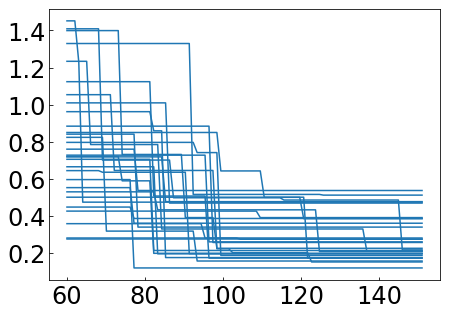

In [24]:
Obj_list = np.load('DiffStarPointTest_newGPT_150iter_30pts.npy')

fig = plt.figure(figsize = (7,5))
for i in range(len(Obj_list)):
    temp = -Obj_list[i,2::]
#     plt.plot(temp[2::], '-',c='C0')
    plt.plot(np.linspace(60,151,91),temp[60::],'-',c='C0')
    
# plt.yscale('log')
# plt.axhline(y = 0.039, c='red', linewidth = 2, label = 'grid search')
# plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.title('GPy with new UCB parameter', fontsize=20)
plt.tick_params(direction='in')
plt.xlabel('Iteration #', fontsize = 20)
plt.ylabel('($\epsilon_\chi$), best seen', fontsize = 20)

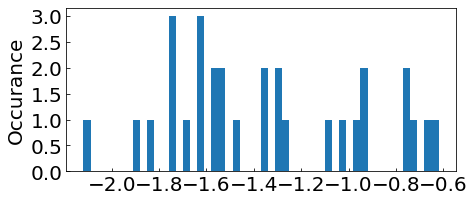

In [25]:
fig = plt.figure(figsize = (7,3))
_ = plt.hist(np.log(-np.asarray(Obj_list)[:,-1]), bins = 50)  # arguments are passed to np.histogram
# plt.title("Histogram with 'auto' bins")
plt.yticks(fontsize=20)
# plt.xticks([])
plt.xticks(fontsize=20)
plt.ylabel('Occurance', fontsize = 20)
plt.tick_params(direction='in')
plt.show()

## Run line scan for each of the parameter

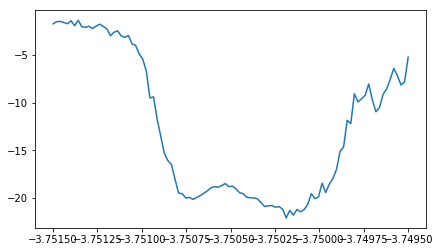

In [9]:
fig = plt.figure(figsize=[7,4])
emit_profile = np.load('OBJ_-3.7515e6_-3.7495e6_100steps_40mrad_CNNemittance.npy')
plt.plot(np.linspace(-3.7515e6,-3.7495e6,num=100)/1e6, emit_profile)

-3749500.0 [-5.61577129]


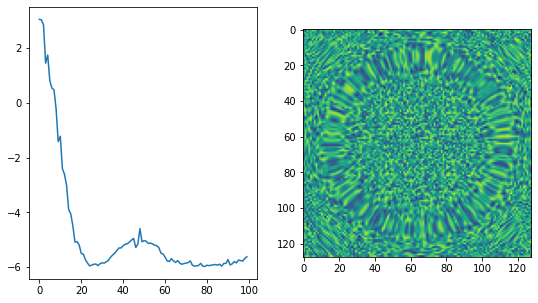

In [3]:
# Line scan for objective lens
ndim = 5 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
# Parameters in the order of H1, H1-H2, S1, S2, S3, S4, S6, S7

OBJ_list = np.linspace(-3.7515e6,-3.7495e6,num=100)
emit_profile = np.zeros([100,1])

for i in range(len(OBJ_list)):

    start_point = [[1498 , 0, 390000 , -654100, OBJ_list[i]]] 
    mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
    mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1
    emit_profile[i] = mi.getState()[1][0]

    clear_output(wait=True)
    print(OBJ_list[i], emit_profile[i])
    fig = plt.figure(figsize = [9,5])
    plt.subplot(121)
    plt.plot(emit_profile)
    temp = np.load('ronchigram.npy')
    
    plt.subplot(122)
    plt.imshow(temp)
    plt.show()
    
    np.save('OBJ_-3.7515e6_-3.7495e6_100steps_40mrad_Coarse_CNNemittance.npy',emit_profile)

1400.0 [-5.29043007]


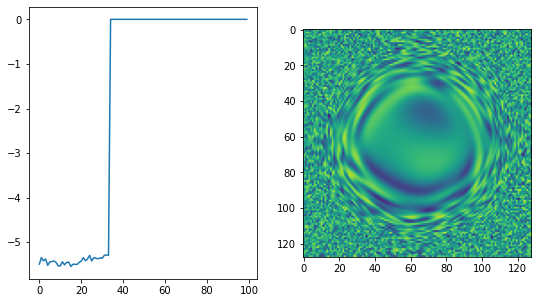

Model loaded


/home/chenyu/Desktop/GaussianProcess/GPTrelated/uscope_calc.py:124: UserWarning: loadtxt: Empty input file: "outscope.txt"
  screen =  np.loadtxt(ASCIIFILE, skiprows=5)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [3]:
# Line scan for H1
ndim = 5 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
# Parameters in the order of H1, H1-H2, S1, S2, S3, S4, S6, S7

H1_list = np.linspace(1000,2200,num=100)
emit_profile = np.zeros([100,1])

for i in range(len(H1_list)):

    start_point = [[H1_list[i] , 0, 390000 , -654100, -3.7505e6]] 
    mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
    mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1
    emit_profile[i] = mi.getState()[1][0]

    clear_output(wait=True)
    print(H1_list[i], emit_profile[i])
    fig = plt.figure(figsize = [9,5])
    plt.subplot(121)
    plt.plot(emit_profile)
    temp = np.load('ronchigram.npy')
    
    plt.subplot(122)
    plt.imshow(temp)
    plt.show()
    
    np.save('H1_1000_2200_100steps_40mrad_Coarse_CNNemittance.npy',emit_profile)

393000.0 [2.80759168]


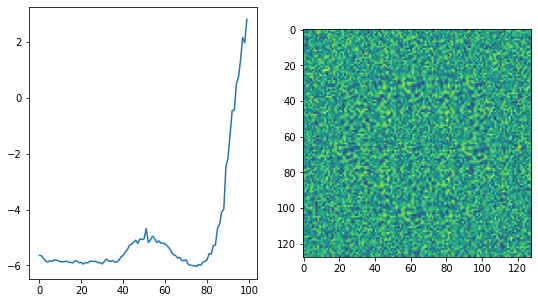

In [3]:
# Line scan for S6
ndim = 5 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
# Parameters in the order of H1, H1-H2, S1, S2, S3, S4, S6, S7

S6_list = np.linspace(387000,391000,num=100)
emit_profile = np.zeros([100,1])

for i in range(len(S6_list)):

    start_point = [[1498.2, 0, S6_list[i], -654100, -3.7505e6]] 
    mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
    mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1
    emit_profile[i] = mi.getState()[1][0]

    clear_output(wait=True)
    print(S6_list[i], emit_profile[i])
    fig = plt.figure(figsize = [9,5])
    plt.subplot(121)
    plt.plot(emit_profile)
    temp = np.load('ronchigram.npy')
    
    plt.subplot(122)
    plt.imshow(temp)
    plt.show()
    np.save('S6_3.87e5_3.91e5_100steps_40mrad_Coarse_CNNemittance.npy',emit_profile)

-640000.0 [-5.94448853]


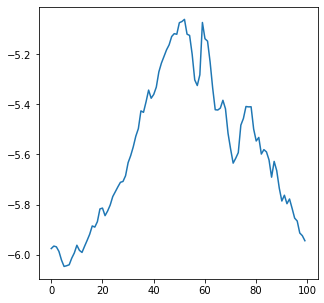

In [3]:
# Line scan for S7
ndim = 5 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
# Parameters in the order of H1, H1-H2, S1, S2, S3, S4, S6, S7

S7_list = np.linspace(-655000,-640000, num=100)
emit_profile = np.zeros([100,1])

for i in range(len(S7_list)):
    print(i)
    start_point = [[1498.2, 0, 391515, S7_list[i], -3.7505e6]] 
    mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
    mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1
    emit_profile[i] = mi.getState()[1][0]

    clear_output(wait=True)
    print(S7_list[i], emit_profile[i])
    fig = plt.figure(figsize = [5,5])
    plt.plot(emit_profile)
    plt.show()
    np.save('S7_-6.55e5_-6.40e5_100steps_40mrad_Coarse_CNNemittance.npy',emit_profile)

20.0 [-5.42629719]


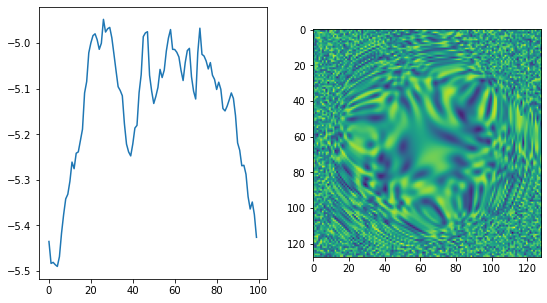

In [4]:
# Line scan for deltaH
ndim = 5 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
# Parameters in the order of H1, H1-H2, S1, S2, S3, S4, S6, S7

deltaH_list = np.linspace(-20, 20, num=100)
emit_profile = np.zeros([100,1])
# emit_profile = np.load('deltaH_-20_20_100steps_40mrad_CNNemittance.npy')

for i in range(len(deltaH_list)):
    
    if emit_profile[i]!=0:
        continue

    start_point = [[1498.2 , deltaH_list[i], 390000 , -654100, -3.7505e6]] 
    mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
    mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1
    emit_profile[i] = mi.getState()[1][0]

    clear_output(wait=True)
    print(deltaH_list[i], emit_profile[i])
    fig = plt.figure(figsize = [9,5])
    plt.subplot(121)
    plt.plot(emit_profile)
    temp = np.load('ronchigram.npy')
    
    plt.subplot(122)
    plt.imshow(temp)
    plt.show()
    
    np.save('deltaH_-20_20_100steps_40mrad_Coarse_CNNemittance.npy',emit_profile)

## Aux Functions

## Previously used scripts

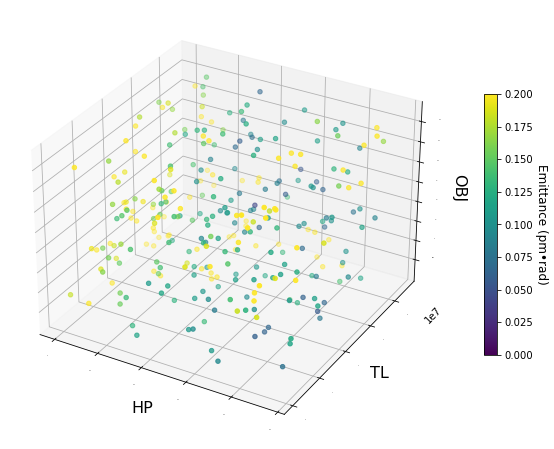

In [52]:
fig = plt.figure(figsize=[15,8])
ax = fig.add_subplot(111, projection='3d')

x_cor = (Status_array[:,3]-1000)*4 + (Status_array[:,4]+2) # from H1 and deltaH
y_cor = (Status_array[:,5]-3.87e5)*0.15e5 + (Status_array[:,6]+6.55e5) # from S6 and S7
z_cor = Status_array[:,7] + 3.7511e6 # from Obj
p = ax.scatter(x_cor, y_cor, z_cor, c=-Status_array[:,1],vmin=0, vmax=0.2)

ax.set_xlabel('HP', fontsize=16)
ax.set_ylabel('TL', fontsize=16)
ax.set_zlabel('OBJ', fontsize=16, rotation=270)
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(0)
cbar = fig.colorbar(p, shrink=0.6)
plt.xticks(fontsize=0)
plt.yticks(fontsize=0)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Emittance (pm\u2022rad)',fontsize = 12, rotation=270)

plt.show()

200000.0 215862.06896551725 -8.96048411718694 -872.8255832750212


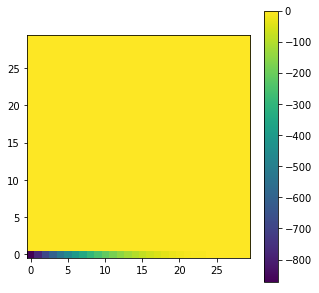

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [50]:
# 2D parameter scan for all (S1, S2) pairs
ndim = 8 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
# Parameters in the order of H1, H1-H2, S1, S2, S3, S4, S6, S7
start_point = [[890, 0, 2.5e5, 2.5e5, 119931.5, 648691.415, 390000, -654100]]

S1_list = np.linspace(2.0e5,2.2e5,num=30)
S2_list = np.linspace(2.5e5, 2.7e5, num=30)
# emit_matrix = np.zeros([30, 30])
emit_matrix = np.load('S1_S2_2.0-2.2e5_2.5-2.7e5.npy')

for i in range(len(S1_list)):
    for j in range(len(S2_list)):
        
        if emit_matrix[i,j]!=0:
            continue
        start_point = [[890, 0, S1_list[i], S2_list[j], 119931.5, 648691.415, 390000, -654100]] 
        mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
        mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1
        emit_matrix[i,j] = mi.getState()[1][0]
        
        clear_output(wait=True)
        print(S1_list[i], S2_list[j], emit_matrix[i,j], np.amin(emit_matrix[emit_matrix!=0]))
        fig = plt.figure(figsize = [5,5])
        plt.imshow(emit_matrix, origin='lower')
        plt.colorbar()
        plt.show()
        fig.savefig('S1_S2_2.0-2.2e5_2.5-2.7e5.png')
        np.save('S1_S2_2.0-2.2e5_2.5-2.7e5.npy',emit_matrix)

-51.01776816563012


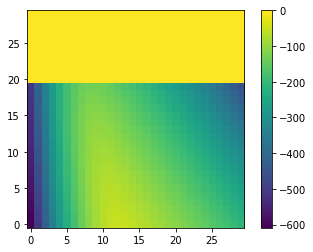

In [46]:
temp = np.load('S1_S2_0-500000.npy')
temp = np.load('S1_S2_2.2-2.4e5_2.5-2.7e5.npy')
temp = np.load('S3_S4_1.1e5-1.3e5_6.0-7.0e5.npy')
plt.imshow(temp, origin='lower')
plt.colorbar()
print(np.amax(temp[temp!=0]))

130000.0 700000.0 -95412.04449227193 -4531207.416809689


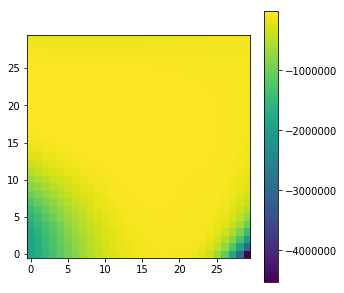

In [54]:
# 2D parameter scan for all (S3, S4) pairs
ndim = 8 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
# Parameters in the order of H1, H1-H2, S1, S2, S3, S4, S6, S7
start_point = [[890, 0, 2.5e5, 2.5e5, 119931.5, 648691.415, 390000, -654100]]

S3_list = np.linspace(110000,130000,num=30)
S4_list = np.linspace(600000,700000, num=30)
# emit_matrix = np.zeros([30,30])
emit_matrix = np.load('S3_S4_1.1e5-1.3e5_6.0-7.0e5.npy')

for i in range(len(S3_list)):
    for j in range(len(S4_list)):
        if emit_matrix[i,j] != 0:
            continue
        start_point = [[890, 0, 2.5e5, 2.5e5, S3_list[i], S4_list[j], 390000, -654100]] 
        mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
        mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1
        emit_matrix[i,j] = mi.getState()[1][0]
        
        clear_output(wait=True)
        print(S3_list[i], S4_list[j], emit_matrix[i,j], np.amin(emit_matrix[emit_matrix!=0]))
        fig = plt.figure(figsize = [5,5])
        plt.imshow(emit_matrix, origin='lower')
        plt.colorbar()
        plt.show()
        fig.savefig('S3_S4_1.1-1.3e5_6.0-7.0e5.png')
        np.save('S3_S4_1.1e5-1.3e5_6.0-7.0e5.npy',emit_matrix)

400000.0 -650000.0 -459.81959195449355


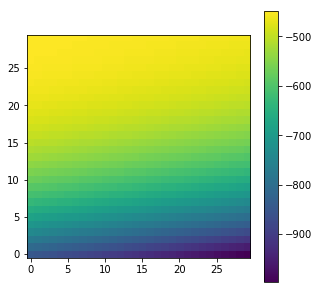

In [32]:
# 2D parameter scan for all (S6, S7) pairs
ndim = 8 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
# Parameters in the order of H1, H1-H2, S1, S2, S3, S4, S6, S7
start_point = [[890, 0, 2.5e5, 2.5e5, 119931.5, 648691.415, 390000, -654100]]

S6_list = np.linspace(380000,400000,num=30)
S7_list = np.linspace(-660000,-650000, num=30)
emit_matrix = np.zeros([30, 30])

for i in range(len(S6_list)):
    for j in range(len(S7_list)):

        start_point = [[890, 0, 2.5e5, 2.5e5, 119931.5, 648691.415, S6_list[i], S7_list[j]]] 
        mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
        mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1
        emit_matrix[i,j] = mi.getState()[1][0]
        
        clear_output(wait=True)
        print(S6_list[i], S7_list[j], emit_matrix[i,j])
        fig = plt.figure(figsize = [5,5])
        plt.imshow(emit_matrix, origin='lower')
        plt.colorbar()
        plt.show()
        fig.savefig('S6_S7_new.png')
        np.save('S6_S7_new.npy',emit_matrix)